In [1]:
#Create a neural network graph and setup training steps for 
# a neural network to use and learn from the MNIST dataset.

# Import modules necessary for MNIST Experiment
import tensorflow as tf

#Import example
from tensorflow.examples.tutorials.mnist import input_data
#Setup data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Create the model
x = tf.placeholder(tf.float32, [None, 784]) #Input values (N images by 784 pixels per image)
W = tf.Variable(tf.zeros([784, 10]))        #Weight values for input (784 pixels by 10 possible digits)
b = tf.Variable(tf.zeros([10]))             #Bias values for each digit
y = tf.nn.softmax(tf.matmul(x, W) + b)      #Output vector, Softmax(Wx + b)

# Define loss placeholder
y_ = tf.placeholder(tf.float32, [None, 10]) #How far is result from actual
# Create cross_entropy function based on loss and actual
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# Instruct TensorFlow to attempt to minimize the cross_entropy using the Gradient Descent 
# Optimizer with a learning value of 0.5
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [100]:
#Create a neural network and save values for display

# importing the required packages
import numpy as np
from sklearn import manifold

#Ignore divide by zero errors, only rare and on first frame
np.seterr(divide='ignore', invalid='ignore')

# Initialize and save variables
init = tf.global_variables_initializer()
sess = tf.Session()     #Start new Session
sess.run(init)          #Initialize variables

## Values used to collect data
#Number of steps to run
num_steps = 40
#Number of samples for data collection
n_samples = 500
#Number of steps between sample collection
sample_gap = 5

#Define a way to save parameters for graph
graphs = np.zeros(shape=(num_steps // sample_gap,    #One dimension for each step in time
                         n_samples,                  #One dimension each sample taken
                         2))                         #One dimension for vector data (2 from a 2d graph)
solutions = np.zeros(shape=(num_steps // sample_gap, #Dimension for each step in time
                            n_samples))              #Saved value for solution
#Define a way to save weight images
weight_images = np.zeros(shape=(num_steps // sample_gap, 10, 28, 28))
#Define batch size
batch_size = 100
#Setup function for computing t-SNE for graphs
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    
# Run training steps Num Steps times
for n in range(num_steps):
    #Before training the neural network, check if this is a sample step
    #Done before so it can include before training
    #Ignore index 0 as all values are set to zero and this can lead to errors
    if n // sample_gap < num_steps // sample_gap and n % sample_gap == 0:
        print("Calculating visual representation, step", n)
        #Load n samples from the training dataset
        #Batch_x are the input images as a flattened 784 pixel vector
        #Batch_y is a vector of what number the image represents
        batch_x, batch_y = mnist.train.next_batch(n_samples)
        X = sess.run(y, feed_dict={x:batch_x})
        
        # (This is slow but precomputed) Computing t-SNE projection
        tsne_vector = tsne.fit_transform(X)
        graphs[n // sample_gap] = tsne_vector;
        
        #Save the solution to this batch
        solutions[n // sample_gap] = np.array([np.argmax(group) for group in batch_y])
                         
        #Save weight images to display later
        weight_images[n // sample_gap] = np.array([np.reshape(sess.run(W)[np.arange(0,784), n], (-756,28)) for n in range(10)])
                  
    #Get a batch of 100 images
    #Batch_x are the input images as a flattened 784 pixel vector
    #Batch_y is a vector of what number the image represents
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    
    #Run the session with the given data (Do one training step)
    sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
    

Calculating visual representation, step 0
Calculating visual representation, step 5
Calculating visual representation, step 10
Calculating visual representation, step 15
Calculating visual representation, step 20
Calculating visual representation, step 25
Calculating visual representation, step 30
Calculating visual representation, step 35


<IPython.core.display.Javascript object>


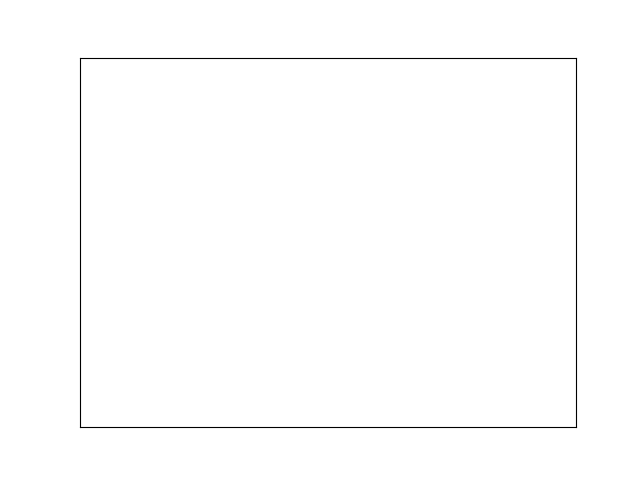

Widget Javascript not detected.  It may not be installed or enabled properly.


In [101]:
# Take the precomputed information and make an interactive graph to showcase the neural network

#Import required libraies
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

# Define colors for plotting numbers
colors = [(0,0,0,1),        #Black for zero
            (1, .5,0, 1),   #Orange for one
            (0, 1, 0, 1),   #Green for two
            (0, 0, 1, 1),   #Blue for three
            (1, 0, 0, 1),   #Red for four
            (1, 0, 1, 1),   #Magenta for five
            (1, 1, .25, 1), #Yellow for six
            (0, 1, 1, 1),   #Teal for seven
            (.5, .25, 1, 1),#Purple for eight
            (.5, .5, .5, 1)#Grey for nine
         ]

%matplotlib notebook

graph_fig = plt.figure()

def update(time_index = 0):
    
    title="t-SNE embedding of the digits"
    #Save the vectors for this plot
    X = graphs[time_index]
    
    #Clear canvas
    graph_fig.clf()
    
    #Calculate min and max of graphs
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    #Normalize values based on input
    X = (X - x_min) / (x_max - x_min)     
    ax = plt.subplot(111)
    for i in range(n_samples):
        num = int(solutions[time_index][i])
        plt.text(X[i, 0], X[i, 1], str(num),
                 color=colors[num],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title + " after " + str(time_index * sample_gap) + " training steps (" + 
                  str(time_index * sample_gap * batch_size) + " images)")
    plt.show()
    
interact(update, time_index = (0, len(graphs) - 1));

(8, 10, 28, 28)


<IPython.core.display.Javascript object>


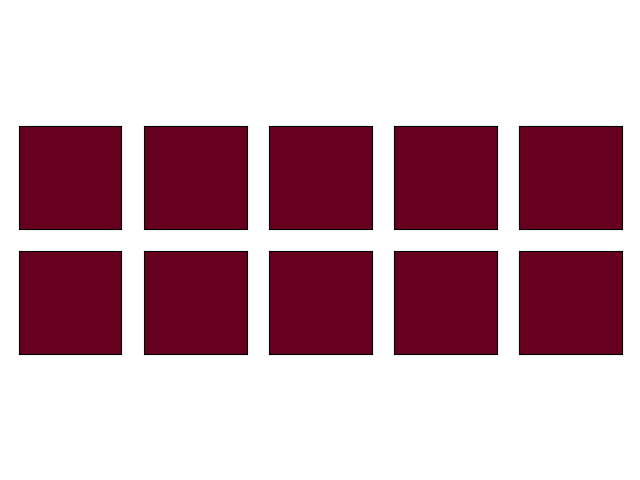

Widget Javascript not detected.  It may not be installed or enabled properly.


In [102]:


print(weight_images.shape)

from matplotlib import cm
from matplotlib import pyplot

%matplotlib notebook

dig_fig = plt.figure()

def update(time_index = 0):
    images = weight_images[time_index]

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        pyplot.imshow(-images[i], interpolation='nearest', cmap=cm.RdGy)
        plt.xticks([]), plt.yticks([])

    plt.tight_layout()
    pyplot.show()

interact(update, time_index = (0, len(graphs) - 1));